In [2]:
import math
import os
import random
import time
import typing

from tqdm import tqdm
import cv2; print(f"OpenCV version: {cv2.__version__}")
import h5py
import matplotlib.pyplot as plt
import numpy as np; print(f"Numpy version: {np.__version__}")
import pandas as pd; print(f"Pandas version: {pd.__version__}")
from PIL import Image
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import torch; print(f"PyTorch version: {torch.__version__}")
import torch.nn as nn
import torch.nn.functional as F
import torchvision

OpenCV version: 4.11.0
Numpy version: 1.26.4
Pandas version: 2.2.2
PyTorch version: 2.5.1+cu124


In [3]:
!pip install mlflow dagshub optuna --quiet
import mlflow
import dagshub
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.8/672.8 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Data preparation

## Download CheXpert dataset

There are two options, one for one time use and another for recurrent use using Google Drive. Execute just the necessary cells.

Ctrl + M M to convert code cell to text

Ctrl + M Y to convert text cell to code

### Option 1: Download directly to Colab session storage
They data will be deleted every time the session is restored. It takes around 5 minutes to download and unzip the dataset.


1. Retrieve a Kaggle API key formatted as as kaggle.json file.
2. Upload it into the content folder (the default one in Files) in the Colab session storage.
3. Execute the following code block.

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # Move API key and set permissions

!kaggle datasets download ashery/chexpert -p /content # Download zip dataset from kaggle
dataset_zip = "/content/chexpert.zip"

!mkdir -p /content/chexpert/CheXpert-v1.0-small
!unzip -q {dataset_zip} -d /content/chexpert/CheXpert-v1.0-small  # Unzip the dataset in appropiate directory

os.remove(dataset_zip) # Remove ZIP file to save space

CHEXPERT_PATH = "/content/chexpert" # Base path of the dataset

### Option 2: Access using Google Drive


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

CHEXPERT_PATH = '/content/drive/MyDrive/chexpert'
print("Content of selected directory:")
!ls {CHEXPERT_PATH}

print("Content of CheXpert-v1.0-small inside selected directory:")
!ls {CHEXPERT_PATH}/CheXpert-v1.0-small


Mounted at /content/drive
Content of selected directory:
'bounding-box annotations'   optuna		    ResNet34_weights.pth
 CheXpert-v1.0-small	    'ranking annotations'  'saliency map poster images'
Content of CheXpert-v1.0-small inside selected directory:
train  train.csv  train.hdf5  valid  valid.csv	valid.hdf5


Inside the selected directory in Drive, you should have a folder called CheXpert-v1.0-small containing the Kaggle dataset.

#### Download the dataset directly to Google Drive

It is possible to download the dataset to Drive directly to the selected CHEXPERT_PATH directory in your drive.

1. Get the Kaggle API key
2. Upload the key into Colab files

from google.colab import files
files.upload()

3. Download the dataset in the Google Drive mount. Takes around 1h.

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!mkdir -p {CHEXPERT_PATH}
!kaggle datasets download ashery/chexpert -p {CHEXPERT_PATH}

!unzip {CHEXPERT_PATH}/chexpert.zip -d {CHEXPERT_PATH}/CheXpert-v1.0-small
!rm {CHEXPERT_PATH}/chexpert.zip

## Dataset exploration

Read the pandas dataframes and filter them only with frontal images.

In [5]:
train_path = CHEXPERT_PATH + "/CheXpert-v1.0-small/train.csv"
train_df = pd.read_csv(train_path)
train_df = train_df[train_df['Frontal/Lateral'] == 'Frontal']
train_df["Patient number"] = train_df["Path"].str.extract(r"patient(\d+)")

test_path = CHEXPERT_PATH + "/CheXpert-v1.0-small/valid.csv"
test_df = pd.read_csv(test_path)
test_df = test_df[test_df['Frontal/Lateral'] == 'Frontal']
test_df["Patient number"] = test_df["Path"].str.extract(r"patient(\d+)")

In [6]:
test_df[test_df["Pleural Effusion"]==1]

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient number
5,CheXpert-v1.0-small/valid/patient64545/study1/...,Female,55,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,64545
10,CheXpert-v1.0-small/valid/patient64548/study1/...,Female,53,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,64548
15,CheXpert-v1.0-small/valid/patient64552/study1/...,Female,84,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,64552
41,CheXpert-v1.0-small/valid/patient64571/study1/...,Male,61,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,64571
48,CheXpert-v1.0-small/valid/patient64577/study1/...,Female,72,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,64577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,CheXpert-v1.0-small/valid/patient64718/study1/...,Male,83,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,64718
213,CheXpert-v1.0-small/valid/patient64720/study1/...,Female,77,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,64720
215,CheXpert-v1.0-small/valid/patient64722/study1/...,Female,81,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,64722
218,CheXpert-v1.0-small/valid/patient64725/study1/...,Male,75,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,64725


The radiographs are labeled for the presence of 14 observations as positive, negative, or uncertain.

In [7]:
LABELS = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
    'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
    'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
    'Pleural Other', 'Fracture', 'Support Devices'
]
NR_LABELS = len(LABELS)

### Pleural effusion label

In [8]:
train_df = train_df[train_df["Pleural Effusion"].notna()]
print(f"Positive pleural effusion samples: {len(train_df[train_df['Pleural Effusion'].astype(int)==1])}")
print(f"Negative pleural effusion samples: {len(train_df[train_df['Pleural Effusion'].astype(int)==0])}")
print(f"Uncertain pleural effusion samples: {len(train_df[train_df['Pleural Effusion'].astype(int)==-1])}")

Positive pleural effusion samples: 76899
Negative pleural effusion samples: 25299
Uncertain pleural effusion samples: 9578


There are aound 10% of uncertain Pleural Effusion datapoints from all the labelled patients. There is a class imbalance favouring the positive label in a ratio of around 3:1.

## Pytorch dataset

In [9]:
class CheXpertDataset(torch.utils.data.Dataset):

  def __init__(self,
               root_dir: str,
               csv_file: str = None,
               hdf5_file: str = None,
               uncertainty: str = "u-ignore",
               subset_ratio: float = 1.0,
               stage: str = "train",
               pretrained: bool = True,
               ranking_instead_of_label: bool = False,
               ):
    self.stage = stage
    self.root_dir = root_dir
    self.transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)), # Resize to 224x224
        torchvision.transforms.ToTensor(),  # Converts image to [0, 1] and to shape (1, 224, 224)
        ])
    self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])
    self.label = "Pleural Effusion"
    self.uncertainty = uncertainty
    self.pretrained = pretrained
    self.ranking_instead_of_label = ranking_instead_of_label
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if self.stage == 'pred':
      self.file_names = [f for f in os.listdir(root_dir)]

    elif self.stage == "preprocess":
      # Load the CSV and filter the dataframe.
      if csv_file is None:
          raise ValueError("csv_file must be provided for preprocess stage.")
      self.data = pd.read_csv(csv_file)
      self.data = self.data[self.data['Frontal/Lateral'] == 'Frontal']  # Select only frontal images
      self.data = self.data[self.data[self.label].notna()]  # Only non-NaN values for the selected label
      self.hdf5_path = csv_file.replace(".csv", ".hdf5")

    elif self.stage == "train":
      # For training, load the preprocessed HDF5 database.
      if hdf5_file is None:
        raise ValueError("hdf5_file must be provided for train stage.")
      self.hdf5_file = hdf5_file
      f = h5py.File(self.hdf5_file, 'r')
      self.images = f["images"]
      self.labels = f["labels"]

      # Load only a subset if desired.
      if subset_ratio < 1.0:
        nr_datapoints = int(len(self.images) * subset_ratio)
        self.images = self.images[:nr_datapoints]
        self.labels = self.labels[:nr_datapoints]

      # Apply the selected uncertainty approach
      labels_all = self.labels[:]
      if self.uncertainty == "u-ignore":
        self.indices = np.where(labels_all != -1)[0] # Keep only non uncertain records.
        self.labels = self.labels[self.indices]
      elif self.uncertainty == "u-zeroes":
        labels_all[labels_all == -1] = 0   # Replace uncertain with negative.
        self.labels_list = labels_all
      elif self.uncertainty == "u-ones":
        labels_all[labels_all == -1] = 1   # Replace uncertain with positive.
        self.labels_list = labels_all
      elif self.uncertainty == "3-class":
        self.labels_list = labels_all
      else:
        raise ValueError("Selected uncertainty method does not exist.")

    else:
        raise ValueError("Stage must be either 'preprocess', 'train' or 'pred'.")


  def __len__(self) -> int:
    if self.stage == "train" and self.uncertainty == "u-ignore":
      return len(self.indices)
    elif self.stage == "train":
      return len(self.labels_list)
    elif self.stage == 'pred':
      return len(self.file_names)
    return len(self.data)

  def __getitem__(self, idx) -> typing.Tuple[torch.tensor, np.float64]:

    if self.stage == "train":

      # Change the index to the whole dataset one if ignoring u labels.
      if self.uncertainty == "u-ignore":
        img_np = self.images[self.indices[idx]]
        label_np = self.labels[idx]
      else:
        img_np = self.images[idx]
        label_np = self.labels_list[idx]

      # Convert numpy arrays to torch tensors.
      image = torch.from_numpy(img_np).float().to(self.device) # shape (1, 224, 224)
      label = torch.from_numpy(label_np).float().to(self.device) # shape (1,)

      # Apply ImageNet normalization if working with pretrained models
      if self.pretrained:
        if image.shape[0] == 1:
          image = image.repeat(3, 1, 1)  # replicate the single channel
        image = self.normalize(image)

      return image, label

    elif self.stage == 'pred':
      img_path = os.path.join(self.root_dir, self.file_names[idx])
      if self.ranking_instead_of_label:
        label = int(self.file_names[idx].split('.')[0].split('_')[1])
      else:
        label = torch.tensor([1])  # -1 as a placeholder for unknown label
      img = Image.open(img_path).convert('RGB')
      img = self.transform(img)
      return img, label

    elif self.stage == "preprocess":
      row = self.data.iloc[idx]
      img_path = os.path.join(self.root_dir, row['Path'])
      label = np.array([row[self.label]])

      image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      if image is None:
          raise RuntimeError(f"Image not found or unable to load: {img_path}")
      image = cv2.resize(image, (224, 224)) # Resize image to 224x224
      image = image.astype(np.float16) / 255.0  # Convert image to float16 and normalize pixel values to [0, 1]
      # image = np.expand_dims(image, axis=0) # shape (1, 224, 224)
      return image, label

  def create_hdf5_db(self,  include_patient_id: bool = False):
    """
    Iterates over the dataset (using __getitem__ for preprocessing) and saves the preprocessed image tensor,
    label, and optionally a patient ID string to an HDF5 file.
    """
    if self.stage != "preprocess":
        raise RuntimeError("create_hdf5_db can only be called in the 'preprocess' stage.")

    num_samples = len(self.data)
    with h5py.File(self.hdf5_path, 'w') as hf:
      # Preallocate datasets. (Images are assumed to be grayscale with shape (1, 224, 224).)
      images_ds = hf.create_dataset("images", shape=(num_samples, 1, 224, 224), dtype=np.float16)
      labels_ds = hf.create_dataset("labels", shape=(num_samples, 1), dtype=np.int64)
      if include_patient_id:
        dt = h5py.string_dtype(encoding='utf-8')
        patient_ids_ds = hf.create_dataset("patient_ids", shape=(num_samples,), dtype=dt)

      for i in tqdm(range(num_samples)):
        # Use __getitem__ to preprocess and obtain torch tensors.
        image, label = self[i]
        # Convert torch tensors to numpy arrays for HDF5 storage.
        images_ds[i] = image
        labels_ds[i] = label
        if include_patient_id:
          # Retrieve patient id from the original dataframe (if available).
          row = self.data.iloc[i]
          patient_id = row.get('PatientID', 'unknown')
          patient_ids_ds[i] = patient_id

      print(f"HDF5 database created at {self.hdf5_path} with {num_samples} samples.")

### Preprocess and save the dataset into HDF5 DB

In [10]:
if not os.path.exists(os.path.join(CHEXPERT_PATH, "CheXpert-v1.0-small", "train.hdf5")):
    all_train_dataset = CheXpertDataset(
        root_dir = CHEXPERT_PATH,
        csv_file = CHEXPERT_PATH + "/CheXpert-v1.0-small/train.csv",
        uncertainty = "u-ignore",
        stage = "preprocess"
        )
    all_train_dataset.create_hdf5_db()
if not os.path.exists(os.path.join(CHEXPERT_PATH, "CheXpert-v1.0-small", "valid.hdf5")):
    test_dataset = CheXpertDataset(
        root_dir = CHEXPERT_PATH,
        csv_file = CHEXPERT_PATH + "/CheXpert-v1.0-small/valid.csv",
        stage="preprocess"
        )
    test_dataset.create_hdf5_db()

### Load models from HDF5 database

In [11]:
all_train_dataset = CheXpertDataset(
    root_dir = CHEXPERT_PATH,
    hdf5_file = CHEXPERT_PATH + "/CheXpert-v1.0-small/train.hdf5",
    uncertainty="u-ones",
    stage="train")
test_dataset = CheXpertDataset(
    root_dir = CHEXPERT_PATH,
    hdf5_file = CHEXPERT_PATH + "/CheXpert-v1.0-small/valid.hdf5",
    stage="train")

print(f"Number training datapoints: {len(all_train_dataset)}")
print(f"Number test datapoints: {len(test_dataset)}")

Number training datapoints: 111776
Number test datapoints: 202


In [12]:
print(all_train_dataset[0][0].shape)

torch.Size([3, 224, 224])


## Pytorch dataloaders

In [13]:
class OversampleNegativeDataLoader(torch.utils.data.DataLoader):
  def __init__(self, dataset, labels, batch_size, num_workers=0, pin_memory=False):
    classes, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(classes, counts))
    # Compute sample weights: inverse frequency of the label
    sample_weights = np.array([1.0 / class_counts[label] for label in labels])

    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    super().__init__(
        dataset=dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False #As we are sampling
    )

def get_dataloaders(batch_size,
                    root_dir = CHEXPERT_PATH,
                    uncertainty: str = "u-ignore",
                    validation: float = 0,
                    train_subset: float = 1,
                    val_split: str = "stratified",
                    pretrained: bool = True,
                    pin_memory: bool = False,
                    verbose: bool = True
                    ):

  all_train_dataset = CheXpertDataset(
      root_dir=root_dir,
      hdf5_file= root_dir + "/CheXpert-v1.0-small/train.hdf5",
      uncertainty=uncertainty,
      pretrained=pretrained,
      subset_ratio=train_subset
      )
  test_dataset = CheXpertDataset(
      root_dir=root_dir,
      hdf5_file= root_dir + "/CheXpert-v1.0-small/valid.hdf5",
      uncertainty=uncertainty,
      pretrained=pretrained
      )

  # Perform train-validation split with the original train set
  if validation:
    if val_split == "stratified":
      train_indices, valid_indices = sklearn.model_selection.train_test_split(
          np.arange(len(all_train_dataset)),
          test_size=validation,
          stratify=all_train_dataset.labels,  # Ensures same class distribution in both splits
          random_state=42  # For reproducibility
          )
      train_dataset = torch.utils.data.Subset(all_train_dataset, train_indices)
      valid_dataset = torch.utils.data.Subset(all_train_dataset, valid_indices)
    elif val_split == "random":
      valid_length = int(validation * len(all_train_dataset))
      train_length = len(all_train_dataset) - valid_length
      train_dataset, valid_dataset = torch.utils.data.random_split(
        all_train_dataset,
        (train_length, valid_length)
        )
      train_indices = train_dataset.indices
    else:
      raise ValueError("Selected validation split method does not exist.")
  else:
    train_dataset = all_train_dataset
    train_indices = np.arange(len(all_train_dataset))

  # To deal with class imbalance, oversample the minority class
  train_dataloader = OversampleNegativeDataLoader(
      dataset = train_dataset,
      labels= np.array(all_train_dataset.labels)[train_indices].squeeze().astype(int),
      batch_size = batch_size
      )
  test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset)
  if validation:
    valid_dataloader = torch.utils.data.DataLoader(
        dataset = valid_dataset,
        batch_size = batch_size,
        shuffle = True,
        num_workers=0,
        pin_memory=pin_memory
        )
  else:
    valid_dataloader = None

  if verbose:
    print(f"Train: {len(train_dataset)} datapoints in {len(train_dataloader)} batches.")
    if validation: print(f"Validation: {len(valid_dataset)} datapoints in {len(valid_dataloader)} batches.")
    print(f"Test: {len(test_dataset)} datapoints.")

  return train_dataloader, valid_dataloader, test_dataloader

# Model training

## Models

In [14]:
class DenseNet121(torch.nn.Module):
  def __init__(self, out_size=1, pretrained=True, nr_trained_layers=1):
    super(DenseNet121, self).__init__()
    self.pretrained = pretrained
    self.nr_trained_layers = nr_trained_layers
    self.model = torchvision.models.densenet121(weights="DEFAULT" if self.pretrained else None)
    if not pretrained:
      self.model.features.conv0 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, out_size)

    if pretrained:
      for param in self.model.parameters():
        param.requires_grad = False
      if nr_trained_layers == 1:
        for param in self.model.classifier.parameters():
          param.requires_grad = True
      if nr_trained_layers == 2:
        for param in self.model.features.denseblock4.parameters():
          param.requires_grad = True

  def forward(self, x):
    x = self.model(x)
    return x

class ResNet34(nn.Module):
  def __init__(self, out_size=1, pretrained=True, nr_trained_layers=0):
    super(ResNet34, self).__init__()
    self.pretrained = pretrained
    self.nr_trained_layers = nr_trained_layers
    self.model = torchvision.models.resnet34(weights="DEFAULT" if pretrained else None)
    if not pretrained:
      self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.fc = nn.Linear(self.model.fc.in_features, out_size)
    if pretrained:
      for param in self.model.parameters():
        param.requires_grad = False
      if nr_trained_layers == 1:
        for param in self.model.fc.parameters():
          param.requires_grad = True
      if nr_trained_layers == 2:
        for param in self.model.layer4.parameters():
          param.requires_grad = True

  def forward(self, x):
    x = self.model(x)
    return x

In [15]:
def n_weights(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"ResNet34 all weights: {n_weights(ResNet34(1, pretrained=False))}")
print(f"ResNet34 last layer weights: {n_weights(ResNet34(1, nr_trained_layers=1))}")
print(f"ResNet34 two last layers weights: {n_weights(ResNet34(1, nr_trained_layers=2))}")
print(f"DenseNet121 all weights: {n_weights(DenseNet121(1, pretrained=False))}")
print(f"DenseNet121 last layer weights: {n_weights(DenseNet121(1, nr_trained_layers=1))}")
print(f"DenseNet121 two last layers weights: {n_weights(DenseNet121(1, nr_trained_layers=2))}")

ResNet34 all weights: 21278913


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 49.1MB/s]


ResNet34 last layer weights: 513
ResNet34 two last layers weights: 13114368
DenseNet121 all weights: 6948609


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 53.0MB/s]


DenseNet121 last layer weights: 1025
DenseNet121 two last layers weights: 2158080


## Train and test functions

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cudnn.benchmark = True

def train(model, params, dataloader_train, dataloader_val):
  print(f"Training the model {model.__class__.__name__} with parameters {params}")
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=params["momentum"], weight_decay=params["weight_decay"])
  loss = torch.nn.BCEWithLogitsLoss()
  min_loss = 1e6

  train_start = []
  train_end = []
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(0, params["nr_epochs"]):
    # Train the model in one iteration of the training data
    train_start.append(time.time()) # training starts
    loss_train, acc_train = train_epoch(model, dataloader_train, optimizer, criterion=loss)
    train_losses.append(loss_train)
    train_accs.append(acc_train)
    train_end.append(time.time()) # training ends

    # Perform validation of the epoch if given validation data
    if dataloader_val != None:
      loss_val, acc_val = validate_epoch(model, dataloader_val, optimizer, criterion=loss)
      val_losses.append(loss_val)
      val_accs.append(acc_val)
      print(f"Epoch {epoch + 1} Training loss: {loss_train:.3f}  Valid loss: {loss_val:.3f}  Train acc: {acc_train:.3f}  Val acc: {acc_val:.3f}")
      if loss_val < min_loss: min_loss = loss_val
    else:
      print(f"Epoch {epoch + 1} Training loss: {loss_train:.3f}  Train acc: {acc_train:.3f}")

  train_time = np.array(train_end) - np.array(train_start)
  print("Training finished. \n Training time for each epoch: {} seconds".format(train_time.round(0)))

  training_metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
  }
  return training_metrics

def train_epoch(model, dataloader_train, optimizer, criterion):
  running_loss = 0.0
  correct = 0
  total = 0
  model.train()

  for batch, (img, target) in enumerate(tqdm(dataloader_train)):

    img, target = img.to(device), target.to(device)
    out = model(img)
    loss = criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    predicted = (out > 0).float()  # since using BCEWithLogitsLoss
    correct += (predicted == target).sum().item()
    total += target.numel()

  acc = correct / total if total > 0 else 0

  return running_loss / len(dataloader_train), acc

def validate_epoch(model, dataloader_val, optimizer, criterion):
  val_loss = 0.0
  correct = 0
  total = 0
  model.eval()

  with torch.no_grad():
    for i, (img, target) in enumerate(tqdm(dataloader_val)):

      img, target = img.to(device), target.to(device)
      out = model(img)
      loss = criterion(out, target)
      val_loss += loss.item()

      predicted = (out > 0).float()
      correct += (predicted == target).sum().item()
      total += target.numel()

  acc = correct / total if total > 0 else 0

  return val_loss / len(dataloader_val), acc

def plot_train_vs_valid(train_metrics, val_metrics, metric_name):
    """
    Plots training and validation metrics over epochs.

    Parameters:
      train_metrics (list or array): Metric values for the training set over epochs.
      valid_metrics (list or array): Metric values for the validation set over epochs.
      metric_name (str): Name of the metric to be plotted (e.g., 'Accuracy', 'Loss').
    """
    epochs = range(1, len(train_metrics) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics, label="Training " + metric_name, marker='o')
    if len(val_metrics) > 0:
      plt.plot(epochs, val_metrics, label="Validation " + metric_name, marker='o')
    plt.xlabel("epochs")
    plt.xticks(ticks=epochs)
    plt.ylabel(metric_name)
    plt.title(f"Training vs validation {metric_name}")
    plt.legend()
    plt.grid(True)

    # Save the plot into a temporary directory
    image_path = os.path.join("/tmp", f"{metric_name}_train_vs_valid.png")
    plt.savefig(image_path)
    plt.close()

    return image_path

def test(model, dataloader_test, checkpoint=None):
  #torch.backends.cudnn.benchmark = True
  print(f"Testing the model {model.__class__.__name__}")

  if checkpoint != None and torch.cuda.is_available():
    model_checkpoint = torch.load(checkpoint)
    model.load_state_dict(model_checkpoint['state_dict'])

  model.to(device)
  model.eval()

  true_labels = []
  predictions = []

  with torch.no_grad():
    for i, (img, target) in enumerate(tqdm(dataloader_test)):

      img, target = img.to(device), target.to(device)
      true_labels.append(target)

      # Ensure proper dimensionality of images
      bs, c, h, w = img.size()
      img = img.view(-1, c, h, w)

      predictions.append(model(img))

  return torch.cat(true_labels, dim=0), torch.cat(predictions, dim=0)


def roc_curve_and_auc(true_labels, probabilities, filename="roc_curve.png"):
    ''' # Convert tensors to numpy arrays.
    if torch.is_tensor(true_labels): true_labels = true_labels.cpu().numpy()
    if torch.is_tensor(predictions): predictions = predictions.cpu().numpy() '''

    ''' # If predictions have more than one dimension, flatten them.
    if predictions.ndim > 1:
        predictions = predictions.flatten() '''

    # Compute ROC curve and AUC score.
    fpr, tpr, _ = sklearn.metrics.roc_curve(true_labels, probabilities)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    # Create ROC plot.
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve, AUC={roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")

    # Save the plot to a temporary directory.
    image_path = os.path.join("/tmp", filename)
    plt.savefig(image_path)
    plt.close()

    return image_path, roc_auc

def confusion_matrix(true_labels, predicted_labels, filename="confusion_matrix.png"):

  ''' # Convert tensors to numpy arrays.
  if torch.is_tensor(true_labels): true_labels = true_labels.cpu().numpy()
  if torch.is_tensor(predictions): predictions = predictions.cpu().numpy() '''


  # Compute confusion matrix.
  cm = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)

  # Create a pandas DataFrame for the confusion matrix.
  df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"],
                            columns=["Predicted 0", "Predicted 1"])

  # Create a heatmap plot of the contingency table.
  plt.figure(figsize=(6, 4))
  sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
  plt.title("Contingency Table")
  plt.ylabel("Actual")
  plt.xlabel("Predicted")

  image_path = os.path.join("/tmp", filename)
  plt.savefig(image_path)
  plt.close()

  return image_path


Training on cpu


## Training experiments

In [17]:
def set_dagshub_mlflow():
  dagshub.init(repo_name="xAI-CheXpert-radiology", repo_owner="alexocayanez", mlflow=True)
  os.environ["MLFLOW_TRACKING_USERNAME"] = "ee47c8c4a6275109d3c8186c17b6b569ed9ef30b"
  os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/alexocayanez/xAI-CheXpert-radiology.mlflow"
  mlflow.set_tracking_uri('https://dagshub.com/alexocayanez/xAI-CheXpert-radiology.mlflow')

def get_or_create_experiment_id(name):
  exp = mlflow.get_experiment_by_name(name)
  if exp is None:
    exp_id = mlflow.create_experiment(name)
    return exp_id
  return exp.experiment_id

set_dagshub_mlflow()

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=46b75305-393b-4e8a-914e-6a89a3eec972&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=aadf95c871e98148046c7816ce27dd6061e46b533ae6fdfe8f79dd2e009f0f78




Output()

Accessing as alexocayanez

Initialized MLflow to track repo "alexocayanez/xAI-CheXpert-radiology"

Repository alexocayanez/xAI-CheXpert-radiology initialized!

In [18]:
def log_train(model, params, train_dataloader, valid_dataloader):
  mlflow.log_params({
        "model_name": model.__class__.__name__,
        "nr_training_datapoints": len(train_dataloader)*params["batch_size"],
        "pretrained": model.pretrained,
        "nr_trained_layers": model.nr_trained_layers,
        "batch_size": params["batch_size"],
        "momentum": params["momentum"],
        "weigth_decay": params["weight_decay"]
      })
  mlflow.log_params(params)

  # Train the model and log the associated metrics
  train_val_metrics = train(model, params, train_dataloader, valid_dataloader)
  mlflow.log_params(train_val_metrics)

  # Plot training vs validation LOSS and log it into mlflow
  loss_plot_path = plot_train_vs_valid(
      train_metrics=train_val_metrics["train_losses"],
      val_metrics=train_val_metrics["val_losses"],
      metric_name="loss"
      )
  mlflow.log_artifact(loss_plot_path)

  # Plot training vs validation ACCURACY and log it into mlflow
  acc_plot_path = plot_train_vs_valid(
      train_metrics=train_val_metrics["train_accs"],
      val_metrics=train_val_metrics["val_accs"],
      metric_name="accuracy"
      )
  mlflow.log_artifact(acc_plot_path)

  return train_val_metrics

def log_test(model, test_dataloader):
  true_labels, predictions = test(model, test_dataloader)
  sigmoid = torch.nn.Sigmoid() # As it is not incorpored in the model
  predicted_labels = (predictions > 0.5).float()

  true_labels = true_labels.cpu()
  predictions = predictions.cpu()
  predicted_labels = predicted_labels.cpu()

  # Compute and log ROC curve and AUC metric
  roc_plot_path, auroc = roc_curve_and_auc(
      true_labels = true_labels,
      probabilities = sigmoid(predictions)
      )
  mlflow.log_artifact(roc_plot_path)
  mlflow.log_metric("AUC", auroc)

  # Log confusion matrix
  confusion_matrix_path = confusion_matrix(true_labels, predicted_labels)
  mlflow.log_artifact(confusion_matrix_path)

  # Log accuracy and F1-score
  mlflow.log_metric(
      "Accuracy",
      sklearn.metrics.accuracy_score(y_true=true_labels, y_pred=predicted_labels)
      )
  mlflow.log_metric(
      "F1-score",
      sklearn.metrics.f1_score(y_true=true_labels, y_pred=predicted_labels)
      )
  mlflow.log_metric(
      "Balanced accuracy",
      sklearn.metrics.balanced_accuracy_score(y_true=true_labels, y_pred=predicted_labels)
      )

def train_test_log_model(model, params, uncertainty="u-ignore", validation=0, train_subset=1):
  model_name = model.__class__.__name__
  assert train_subset>=0 and train_subset<=1
  assert validation>=0 and validation<=1

  if validation:
    experiment_id = get_or_create_experiment_id("Train_val_and_test")
  else:
    experiment_id = get_or_create_experiment_id("Train_and_test")

  with mlflow.start_run(experiment_id=experiment_id):

    train_dataloader, valid_dataloader, test_dataloader = get_dataloaders(
        batch_size = params["batch_size"],
        validation = validation,
        train_subset = train_subset,
        uncertainty = uncertainty
        )
    mlflow.log_params({"uncertainty": uncertainty})

    log_train(model, params, train_dataloader, valid_dataloader)
    log_test(model, test_dataloader)

    input_shape = (3, 224, 224) if model.pretrained else (1, 224, 224)
    input_example = torch.zeros(input_shape, dtype=torch.float32).unsqueeze(0).to(device)
    signature = mlflow.models.infer_signature(model_input=input_example, model_output=model(input_example))
    mlflow.pytorch.log_model(
        model.cpu(),
        artifact_path = f"{model_name}-model",
        signature = signature
        )


def tune_hyperparameters(model_class, uncertainty="u-ignore", n_trials=20, validation=0.1, train_subset=1, log_n_best=0, max_nr_epochs=4):
  """
  Hyperparameter tuning using optuna for a given model class.

  Parameters:
    model (class): The model class (e.g., DenseNet121 or ResNet34) to be tuned.
    n_trials (int): Number of optuna trials.
    validation (float): Fraction of training data to use as validation.
    train_subset (float): Fraction of the training set to use (for developing).
    log_n_best (int): Number of best trials to retrain/log in the final experiment.

  Returns:
    study (optuna.Study): The completed optuna study.
  """
  experiment_name = f"{model_class.__name__}_{uncertainty}_hp_tuning"
  experiment_id = get_or_create_experiment_id(experiment_name)
  mlflow.set_experiment(experiment_name)

  def objective(trial):
    use_weight_decay = trial.suggest_categorical("use_weight_decay", [True, False])
    params = {
        "pretrained": True,  #bool(trial.suggest_int("pretrained", 0, 1)),
        "lr": trial.suggest_float("lr", 1e-6, 1e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        "nr_epochs": trial.suggest_int("nr_epochs", 1, max_nr_epochs),
        "momentum" : trial.suggest_float("momentum", 0.5, 0.99),
        "weight_decay" : trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True) if use_weight_decay else 0.0
    }

    # Create a new nested mlflow run for each trial
    with mlflow.start_run(nested=True):

      model_instance = model_class(out_size=1, pretrained=params["pretrained"])

      train_dataloader, valid_dataloader, _ = get_dataloaders(
          batch_size=params["batch_size"],
          validation=validation,
          train_subset=train_subset,
          uncertainty=uncertainty,
          verbose=False
      )
      train_metrics = log_train(model_instance, params, train_dataloader, valid_dataloader)

      # Choose the final validation loss (or training loss if validation is not provided)
      if valid_dataloader is not None and len(train_metrics["val_losses"]) > 0:
          val_loss = train_metrics["val_losses"][-1]
      else:
          val_loss = train_metrics["train_losses"][-1]

      mlflow.log_metric("val_loss", val_loss)

    return val_loss

  # Create and run the optuna study minimizing the validation loss
  with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_params({"uncertainty": uncertainty})
    study = optuna.create_study(
      study_name = experiment_name,
      direction = "minimize",
      storage = f"sqlite:///{os.path.join(CHEXPERT_PATH, 'optuna')}/{experiment_name}.db",
      load_if_exists = True
      )
    study.optimize(objective, n_trials=n_trials)

  # After optimization, log the best model in the study
  if log_n_best>0:
    log_n_best_trials(n=log_n_best, study=study)
  return study

def log_n_best_trials(n, model_class, uncertainty, study=None):
  if study is None:
    experiment_name = f"{model_class.__name__}_{uncertainty}_hp_tuning"
    study = optuna.create_study(
        study_name = experiment_name,
        direction = "minimize",
        storage = f"sqlite:///{os.path.join(CHEXPERT_PATH, 'optuna')}/{experiment_name}.db",
        load_if_exists = True
        )

  # Get the trials with less validation error
  best_trials = sorted([t for t in study.trials if t.value is not None], key=lambda t: t.value)[:n]

  # For each of the best trials, retrain on the full training set and log with train_test_log_model.
  for trial in best_trials:
      best_params = trial.params
      model_instance = model_class(out_size=1, pretrained=True)
      print(f"Retraining model with parameters: {best_params} and val_loss: {trial.value}")
      train_test_log_model(model_instance, params=best_params, uncertainty=uncertainty, validation=0, train_subset=1)

# Explanations

## Model selection

To view all the trained models and the experiments made go to the [experiment repository](https://dagshub.com/alexocayanez/xAI-CheXpert-radiology.mlflow). The experiment "train_and_test" refers to the models trained in the full training set. Select one of the runs and go to the artifacts section, where you can copy the model uri.

In [19]:
set_dagshub_mlflow()
def load_model(model_name, model_version):
  model_uri = f"models:/{model_name}/{model_version}"
  selected_model = mlflow.pytorch.load_model(model_uri, map_location=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
  return selected_model

def save_model_weights(model, whole_class=True):
  if whole_class:
    torch.save(model.state_dict(), os.path.join(CHEXPERT_PATH, f"{model.__class__.__name__}_weights.pth"))
  else:
    torch.save(model.state_dict(), os.path.join(CHEXPERT_PATH, f"{model.__class__.__name__}_weights.pth"))

model = load_model(model_name="u-ignore_ResNet43", model_version=3).to(device)
save_model_weights(model)


Initialized MLflow to track repo "alexocayanez/xAI-CheXpert-radiology"

Repository alexocayanez/xAI-CheXpert-radiology initialized!

2025/03/09 22:21:45 WARNING mlflow.pytorch: Stored model version '2.6.0+cu124' does not match installed PyTorch version '2.5.1+cu124'


In [20]:
model = ResNet34(out_size=1, pretrained=True, nr_trained_layers=2)
model.load_state_dict(torch.load(os.path.join(CHEXPERT_PATH, f"{model.__class__.__name__}_weights.pth")))
model = model.model

<ipython-input-20-3f251dc056c2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CHEXPERT_PATH, f"{model.__class__.__name__}_we

In [21]:
train_ranking_folder = 'ranking annotations/train'
train_ranking_path = os.path.join(CHEXPERT_PATH, train_ranking_folder)
train_ranking_dataset = CheXpertDataset(root_dir=train_ranking_path, stage='pred', ranking_instead_of_label=True)

test_ranking_folder = 'ranking annotations/test'
test_ranking_path = os.path.join(CHEXPERT_PATH, test_ranking_folder)
test_ranking_dataset = CheXpertDataset(root_dir=test_ranking_path, stage='pred')

## Example-based


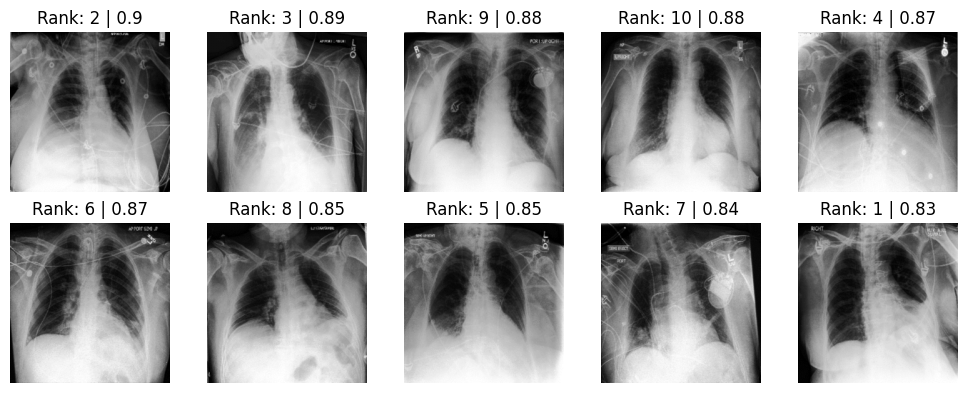

The normalized Discounted Cumulative Gain is 0.9127365838947418


In [23]:
class ExampleBasedExplanations:
  def __init__(self, model, metric="cosine") -> None:
     self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
     assert metric in ["euclidean", "manhattan", "cosine"], "Incorrect selected metric"
     self.metric = metric
     self.latent_model = nn.Sequential(*list(list(model.children())[0].children())[:-1]).to(self.device)
     self.eb_train_data = self.prepare_dataset(train_ranking_dataset)
     self.eb_test_data = self.prepare_dataset(test_ranking_dataset)
     self.train_data_sim = [(example[0], example[1], example[2], self.compare_latents(self.eb_test_data[0][0], example[0], metric = self.metric) ) for example in self.eb_train_data]
     self.sorted_data = sorted(self.train_data_sim, key=lambda x: x[3], reverse=True)

  def prepare_dataset(self, data):
    return [ [self.latent_model(img.unsqueeze(0).to(self.device)).flatten().detach(), img, rank] for img, rank in data]

  def compare_latents(self, latent1, latent2, metric):
    if metric == "euclidean":
      return torch.norm(latent1 - latent2, p=2).item()
    elif metric == "manhattan":
      return torch.norm(latent1 - latent2, p=1).item()
    elif metric == "cosine":
      return F.cosine_similarity(latent1.unsqueeze(0), latent2.unsqueeze(0)).item()

  def plot_ranking_images(self, n_rows=2, n_cols=5):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
      if i < len(self.sorted_data):
        img = self.sorted_data[i][1][0].cpu().numpy()
        rank = self.sorted_data[i][2]
        if img.ndim == 2:
          ax.imshow(img, cmap="gray")
        else:
          ax.imshow(img)
        ax.set_title(f"Rank: {rank}" + " | " + f"{round(self.sorted_data[i][3], 2)}")
        ax.axis("off")
      else:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


  def ndcg(self):
    def dcg(relevance_scores):
      return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores))

    sorted_by_similarity = sorted(self.train_data_sim, key=lambda x: x[3], reverse=True)

    relevance_values = np.linspace(1, 5.5, 10)
    real_ranks = sorted(self.train_data_sim, key=lambda x: int(x[2]))
    relevance_mapping = {real_ranks[i][2]: relevance_values[-(i+1)] for i in range(10)}

    # Compute DCG for predictions
    predicted_relevance = [relevance_mapping[item[2]] for item in sorted_by_similarity]
    dcg_value = dcg(predicted_relevance)

    # Compute IDCG for ideal
    ideal_relevance = sorted(relevance_mapping.values(), reverse=True)
    idcg_value = dcg(ideal_relevance)

    return dcg_value / idcg_value if idcg_value > 0 else 0


example_based = ExampleBasedExplanations(model)
example_based.plot_ranking_images()
print(f"The normalized Discounted Cumulative Gain is {example_based.ndcg()}")

nDCG takes value from 0 (reversed ranking) to 1 (perfect ranking)

In our case it is 0.91 which is strong ranking quality with the mistakes that can be seen on the plot above.


## Saliency Map


In [24]:
!pip install quantus captum --quiet
import captum
import quantus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.1 MB/s eta 0:00:00


In [33]:
class SaliencyMap:
  def __init__(self, model) -> None:
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.model = model.to(device)
    self.last_conv_layer = self.get_last_conv_layer()
    self.x_batch, self.y_batch = SaliencyMap.get_saliency_map_test_data()
    self.s_batch = SaliencyMap.get_masks().unsqueeze(1).cpu().numpy()
    self.metrics =  {
        "Faithfulness": quantus.PixelFlipping(
            features_in_step=224,
            perturb_baseline="black",
            perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
            ),
         "Robustness": quantus.LocalLipschitzEstimate(
            nr_samples=5,
            perturb_std=0.2,
            perturb_mean=0.0,
            norm_denominator=quantus.similarity_func.distance_euclidean,
            perturb_func=quantus.perturb_func.gaussian_noise,
            similarity_func=quantus.similarity_func.lipschitz_constant,
            ),
        "Localisation": quantus.RelevanceMassAccuracy(),
        "Complexity": quantus.Complexity(),
        "Randomisation": quantus.MPRT(
            layer_order="bottom_up",
            similarity_func=quantus.similarity_func.correlation_spearman,
            ),
          }

  def get_last_conv_layer(self):
    if self.model.__class__.__name__ == "ResNet":
      return self.model.layer4[-1].conv2
    elif self.model.__class__.__name__ == "DenseNet":
      return self.model.features[-1]

  def get_saliency_map_test_data(images_indices = [1, 2, 3, 5]):
    x_batch = []; y_batch = []

    x_batch.append(test_ranking_dataset[0][0].detach().cpu().numpy())
    y_batch.append(np.array([0]))

    for i in images_indices:
      img = train_ranking_dataset[train_ranking_dataset.file_names.index(f"Rad_{i}.png")][0]
      x_batch.append(img.detach().cpu().numpy())
      # y_batch.append(train_ranking_dataset[idx][1].detach().cpu().numpy())
      y_batch.append(np.array([0]))

    return np.stack(x_batch), np.stack(y_batch)

  def get_a_batch(model, inputs, targets, explanation="lrp", gradcam_conv_layer = None, nr_att_channels=3, device="cpu"):
    model = model.to(torch.device(device))
    assert inputs.shape[0] == targets.shape[0]

    def get_attribution(tensor, explanation, nr_att_channels):
      if explanation == "lrp":
        exp_method = captum.attr.LRP(model)
      elif explanation == "gradcam":
        exp_method = captum.attr.GuidedGradCam(model, layer=gradcam_conv_layer)
      elif explanation == "saliency":
        exp_method = captum.attr.Saliency(model)
      elif explanation == "int-grad":
        exp_method = captum.attr.IntegratedGradients(model)
      else:
        raise ValueError("Select a vaild explanation method.")
      attribution = exp_method.attribute(tensor, target=0)
      if attribution.shape[1] > nr_att_channels:
        attribution = attribution.mean(dim=1, keepdim=True)
      return attribution

    a_batch = [
      get_attribution(
        tensor = torch.from_numpy(inputs[i]).to(torch.device(device)).unsqueeze(0),
        explanation = explanation,
        nr_att_channels = nr_att_channels
        ).squeeze().detach().cpu().numpy() for i in range(inputs.shape[0])
        ]
    return np.stack(a_batch)

  def get_masks():
    bboxes_path = CHEXPERT_PATH + "/bounding-box annotations/bb-annotations.xlsx"
    df = pd.read_excel(bboxes_path)
    df.columns = df.columns.str.strip()
    image_masks = {}

    # Function to convert multiple bounding-boxes into a single binary mask
    def bbox_to_mask(bboxes, img_size=(320, 320)):
      mask = np.zeros(img_size, dtype=np.uint8)
      for (x_min, y_min, x_max, y_max) in bboxes:
        if not np.isnan([x_min, y_min, x_max, y_max]).any():  # Ignore NaN values
          mask[int(y_min):int(y_max), int(x_min):int(x_max)] = 1  # Fill bounding box area
      return mask

    # Process bounding boxes for each image
    for _, row in df.iterrows():
      image_id = row["Image"]
      # Collect all bounding boxes for this image
      bboxes = [(row["x_start"], row["y_start"], row["x_end"], row["y_end"])]
      # Check if there is a second bounding box and add it
      if not pd.isna(row.get("x_start.1")):
        bboxes.append((row["x_start.1"], row["y_start .1"], row["x_end .1"], row["y_end.1"]))
      # Generate and store mask
      image_masks[image_id] = bbox_to_mask(bboxes)

    masks = torch.tensor(np.array(list(image_masks.values())), dtype=torch.float32)
    resize = torchvision.transforms.Resize((224, 224), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
    return resize(masks).squeeze(1)


  def get_explanations(self, explanation_method):
    return SaliencyMap.get_a_batch(
        model = self.model,
        inputs = self.x_batch,
        targets = self.y_batch,
        explanation = explanation_method
    )

  def plot_explanation(self, img_index, explanation_method, plot_image=True, plot_mask=False):

    def array_3d_to_2d(array):
      array = np.squeeze(array)  # Remove singleton dimensions
      if array.ndim == 3 and array.shape[0] == 3:
        return np.mean(array, axis=0)  # Convert to grayscale by averaging channels
      elif array.ndim == 3 and array.shape[0] == 1:
        return array[0]  # Take the single channel
      else:
        raise ValueError("Input array must have shape (3, H, W) or (1, H, W)")

    def overlay_heatmap(img, att):
      #att = cv2.resize(att, (img.size[0], img.size[1]))  # Resize CAM to match image
      heatmap = cv2.applyColorMap(np.uint8(255 * att), cv2.COLORMAP_JET)  # Apply colormap
      heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      superimposed_img = np.float32(heatmap) * 0.4 + np.float32(img)
      superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
      return superimposed_img, heatmap

    assert 0 <= img_index < len(self.x_batch)
    explanations = self.get_explanations(explanation_method)
    masks = SaliencyMap.get_masks().numpy()

    print(f"Image is type {type(self.x_batch[img_index])} with shape {self.x_batch[img_index].shape}")
    print(f"Explanation is type {type(explanations[img_index])} with shape {explanations[img_index].shape}")
    print(f"Mask is type {type(masks[img_index])} with shape {masks[img_index].shape}")

    img = self.x_batch[img_index]
    # Assuming the image is in (C, H, W) format (with C=3)
    if img.ndim == 3 and img.shape[0] == 3:
        img_disp = np.transpose(img, (1, 2, 0))
    else:
        img_disp = img

    # Prepare the explanation heatmap.
    exp = explanations[img_index]
    if exp.ndim == 3:
        exp_disp = array_3d_to_2d(exp)
    else:
        exp_disp = exp

    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot background layers if requested.
    # Note: they are drawn first so that the explanation (always plotted) remains visible.
    if plot_image:
        ax.imshow(img_disp, interpolation='nearest')
    if plot_mask:
        ax.imshow(masks[img_index], cmap='gray', alpha=0.4, interpolation='nearest')

    # Always overlay the explanation on top.
    im = ax.imshow(exp_disp, cmap='jet', alpha=0.6, interpolation='nearest')
    ax.set_title("Explanation Overlay")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.show()

  def quantus_evaluation(self, explanation):
    self.model.eval()
    gradcam_conv_layer = self.last_conv_layer if explanation == "gradcam" else None

    for name, metric in self.metrics.items():
      s_b = self.s_batch if name=="Localisation" else None
      explain_func_kwargs = {"explanation": explanation, "gradcam_conv_layer": gradcam_conv_layer}
      if name in ["Localisation", "Complexity"]:
          explain_func_kwargs["nr_att_channels"] = 1
      scores = metric(
          model=self.model,
          x_batch=self.x_batch,
          y_batch=self.y_batch,
          a_batch=None,
          s_batch = s_b,
          explain_func=SaliencyMap.get_a_batch,
          explain_func_kwargs=explain_func_kwargs,
          device='cuda:0' if torch.cuda.is_available() else 'cpu'
          )
      if name == "Faithfulness":
          scores = [np.trapz(y=score, x=np.linspace(0, 1, len(score))) for score in scores] # get AUC for PixelFlipping
      if name == "Randomisation":
          quantus.helpers.plotting.plot_model_parameter_randomisation_experiment(results=scores)
          scores_dict = scores.copy()
          scores_dict.pop("original", None)
          all_corrs = []
          for layer_name, corr_values in scores_dict.items():
              all_corrs.extend(corr_values)
          scores = all_corrs

      print(f"{metric.__class__.__name__} scores: {scores}")
      print(f"{metric.__class__.__name__} average score: {np.mean(scores)}")


sm = SaliencyMap(model)
print(sm.x_batch.shape)
print(sm.y_batch.shape)
#print(sm.get_explanations(explanation_method="int-grad").shape)
print(sm.s_batch.shape)

(5, 3, 224, 224)
(5, 1)
(5, 3, 224, 224)
(5, 1, 224, 224)


### Saliency map examples

Image is type <class 'numpy.ndarray'> with shape (3, 224, 224)
Explanation is type <class 'numpy.ndarray'> with shape (3, 224, 224)
Mask is type <class 'numpy.ndarray'> with shape (224, 224)


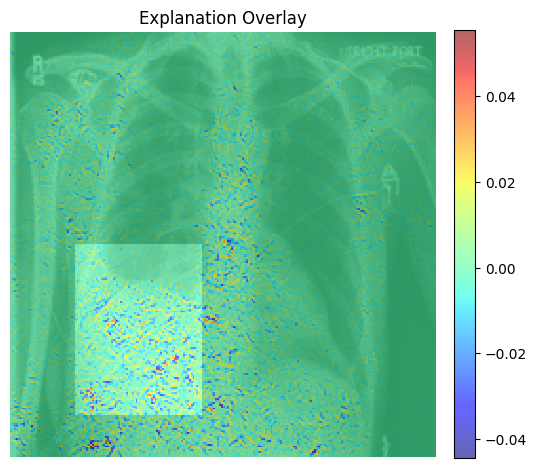

In [34]:
sm.plot_explanation(img_index=0, explanation_method="int-grad", plot_image=True, plot_mask=True)


### Saliency map evaluation

In [ ]:
sm.quantus_evaluation(explanation="lrp")

In [ ]:
sm.quantus_evaluation(explanation="gradcam")

In [ ]:
sm.quantus_evaluation(explanation="int-grad")

### GradCAM

In [ ]:
import torchvision.transforms as transforms

In [ ]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image, input_tensor

In [ ]:
def overlay_heatmap(image, cam):
    cam = cv2.resize(cam, (image.size[0], image.size[1]))  # Resize CAM to match image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Apply colormap
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Overlay heatmap on original image
    superimposed_img = np.float32(heatmap) * 0.4 + np.float32(image)
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))

    return superimposed_img, heatmap

In [ ]:
model.train()

image_path = CHEXPERT_PATH + "/ranking annotations/test/test_image.png"# #other example: "/ranking annotations/train/Rad_5.png"
image, input_tensor = preprocess_image(image_path)
input_tensor = input_tensor.to(device)

# Initialize Grad-CAM
grad_cam = GradCAM(model, last_conv_layer)

# Get Grad-CAM heatmap for Pleural Effusion class
cam = grad_cam.generate_cam(input_tensor, target_class=0)

# Overlay heatmap
superimposed_image, heatmap = overlay_heatmap(image, cam)

# Show result
plt.figure(figsize=(8,8))
plt.imshow(superimposed_image)
plt.axis("off")
plt.show()

In [ ]:
from PIL import Image

In [ ]:
# Load the PNG image using PIL
image = Image.open(image_path).convert("RGBA")  # Convert to RGBA for transparency

# Ensure that the mask is in the same size as the image (224, 224)
mask = masks[0].numpy()  # Convert tensor to numpy array
mask_resized = np.resize(mask, (224, 224))

# Normalize the mask to have values between 0 and 1
mask_normalized = mask_resized.astype(np.float32)  # Ensure mask is float32 for proper blending

# Create an RGBA image from the mask
# Red color for the mask
mask_image = np.zeros((224, 224, 4), dtype=np.uint8)
mask_image[..., 3] = (mask_normalized * 60).astype(np.uint8)  # Red channel
mask_image[..., 0] = 255  # Set green and blue channels to 255 (white)

# Convert mask image to PIL format
mask_pil = Image.fromarray(mask_image, 'RGBA')

# Resize the mask to match the size of the original image
image_resized = image.resize((224, 224), Image.BICUBIC)

# Overlay the mask on top of the image (blending the mask with transparency)
image_with_mask = Image.alpha_composite(image_resized, mask_pil)

# Convert the image back to RGB
image_with_mask_rgb = image_with_mask.convert("RGB")

# Show the image with the overlayed mask
plt.imshow(image_with_mask_rgb)
plt.axis('off')
plt.show()


# Evaluations

LRP mean robustness: 0.076258015191275

GradCAM mean robustness: 0.13654670997073

GradCAM mean localisation:
0.368430566

LRP mean localisation:
0.6199933311


LRP complexity mean: 7.2749101705688

GradCAM complexity mean: 9.7277432989401